<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
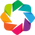

In [1]:
from tools import analysistools as atools
import nanoparticle
from nanoparticle import Ligand, NanoParticle
import math
from membranesimulation import MembraneSimulation
import numpy as np
from tools import icosatiler
from tools import vectools
from tools import misctools
import k3d
import os
import random
import pickle
from numpy import pi, cos, sin, arccos, arange
import networkx as nx


import csv
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
import holoviews.plotting.bokeh
import bokeh
hv.extension('bokeh','matplotlib')
%output widgets='live' holomap='scrubber'
%opts GridSpace [shared_xaxis=True shared_yaxis=True]
import warnings
from IPython.display import display, HTML


In [2]:
mag = lambda v : np.sqrt(np.sum([i*i for i in v]))

In [3]:
def goldenSpiral(n,rad):
    num_pts = 60
    indices = arange(0, n, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/n)
    theta = pi * (1 + 5**0.5) * indices
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    sphs = []
    for i in range(len(x)):
        spp = icosatiler.crt2SphPol((x[i],y[i],z[i]))
        spp = (rad,spp[1],spp[2])
        sphs.append(spp)
    return sphs
    

In [4]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
def norm(v):
    m = mag(v)
    vN = [float(i)/float(m) for i in v]
    return vN

In [6]:
def crossProd(u,v):
    return ((u[1]*v[2]-u[2]*v[1]),(u[2]*v[0]-u[0]*v[2]),(u[0]*v[1]-u[1]*v[0]))

In [7]:
def makeParticleModelFromPhenome(particle):
    points = []
    plot = k3d.plot()
    i = 1
    maxEps = 0
    for l in particle.ligands:
        if l.eps>maxEps:
            maxEps = l.eps
    for l in particle.ligands:
        if l.eps > 0.0:
            lx = l.rad*np.sin(l.polAng)*np.cos(l.aziAng)
            ly = l.rad*np.sin(l.polAng)*np.sin(l.aziAng)
            lz = l.rad*np.cos(l.polAng)
            lc = '0x' + ('#%02x%02x%02x' % (0, int((l.eps/maxEps)*255.0), 0))[1:]
            
            plot += k3d.points([lx,ly,lz],point_size=1,color=int(lc, 16))
            #plot += k3d.points([lx,ly,lz],point_size=1,color=int(0x00ffff*(l.eps/maxEps)))
            plot += k3d.text(str(i),[lx,ly,lz],color=0xffffff)
            i+=1
    plot += k3d.points([0,0,0],point_size=7,color=0xff0000)
    return plot

In [8]:
def buildCoveredParticle(eps,rad):
    particle = NanoParticle()
    lPos = icosatiler.cover72SpherePolar(rad)
    for v in lPos:
        particle.addLigand(Ligand(eps,1,v[0],v[1],v[2]))
    return particle

In [29]:
def buildRandomParticle(eps,rad,indpb):
    particle = buildCoveredParticle(eps,rad)
    for l in particle.ligands:
        if random.uniform(0,1) > indpb:
            l.eps = 0.0
    return particle

In [47]:
def buildRandomFixedParticle(eps,rad,num):
    particle = buildCoveredParticle(eps,rad)
    for l in random.sample(particle.ligands,len(particle.ligands)-num):
            l.eps = 0.0
    return particle

In [10]:
def spaceIsOccupied(particle,v):
    for l in particle.ligands:
        d = atools.greatArcDist((l.polAng,l.aziAng),(v[1],v[2]),particle.sig)
        if abs(d) < l.size:
            return True
    return False

In [11]:
def getClosestIcos(particle,v):
    lPos = icosatiler.cover72SpherePolar(particle.sig)
    closest = v
    minD = 1e8
    for l in lPos:
        v1 = icosatiler.sphPol2Crt(l) 
        v2 = icosatiler.sphPol2Crt(v)
        d = np.sum([j*j for j in np.subtract(v1,v2)])
        if abs(d) < minD:
            minD = d
            closest = l
    return closest

In [12]:
# lPos = icosatiler.cover72SpherePolar(4)
# dists = []
# minD = 1e8
# for v in lPos:
#     for l in lPos:
#         if l != v:
#             v1 = icosatiler.sphPol2Crt(l) 
#             v2 = icosatiler.sphPol2Crt(v)
#             d = np.sum([j*j for j in np.subtract(v1,v2)])
#             if abs(d) < minD:
#                 minD = d
#     dists.append(np.sqrt(minD))
# print np.mean(dists)

In [13]:
def addLigand(particle,eps,v,lock=False):
    if lock:
        v = getClosestIcos(particle,v)
    if not spaceIsOccupied(particle,v):
        particle.addLigand(Ligand(eps,1,v[0],v[1],v[2]))
    return particle

In [14]:
def addBelt(particle,eps,rad,n,phi,lock=False):
    step = np.pi*2/float(n)
    for i in range(n):
        v = (rad,step*i,phi)
        particle = addLigand(particle,eps,v,lock)
    return particle

In [15]:
def getArcAngle(dist,rad):
    return dist/rad

In [16]:
def addRing(particle,eps,rad,pos,n,spacing,lock=False):
    step = np.pi*2/float(n)
    if lock:
        origin = getClosestIcos(particle,(rad,pos[0],pos[1]))
        pos = (origin[1],origin[2])
    for i in range(n):
        tD = getArcAngle(spacing,rad)
        tP = step*i
        v = (rad,tD,tP)
        vC = icosatiler.sphPol2Crt(v)
        v1 = icosatiler.sphPol2Crt((rad,0,0))
        v2 = icosatiler.sphPol2Crt((rad,pos[0],pos[1]))
        v3 = crossProd(v1,v2)
        if np.sum([j*j for j in v3])== 0.0:
            #it's parallel!
            particle = addLigand(particle,eps,v,lock)
            continue
        dp = np.dot(v1,v2)
        #the magic sauce :)
        ang = np.arctan2(mag(np.cross(v1,v2)), np.dot(v1,v2))
        rM = vectools.buildERMatrix(v3, ang)
        vC = np.dot(rM,vC)
        v = icosatiler.crt2SphPol(vC)
        particle = addLigand(particle,eps,v,lock)
    return particle

In [17]:
def addPatch(particle,eps,rad,pos,n,spacing,lock=False):
    if lock:
        origin = getClosestIcos(particle,(rad,pos[0],pos[1]))
        pos = (origin[1],origin[2])
    particle = addLigand(particle,eps,(rad,pos[0],pos[1]),lock)
    particle = addRing(particle,eps,rad,pos,n,spacing,lock)
    return particle

In [18]:
def addMesh(particle,eps,rad,n,lock=False):
    mesh = goldenSpiral(n,particle.sig)
    for point in mesh:
        particle = addLigand(particle,eps,point,lock)
    return particle

In [19]:
def addSphericalSpiral(particle,eps,rad,n,a,limit=5*np.pi,lock=False):
    tstep = (2.0*float(limit))/float(n)
    xs = []
    ys = []
    zs = []
    for i in range(int(n)):
        t = -float(limit) + tstep*float(i)
        x = (np.cos(t))/(np.sqrt(1+a*a*t*t))
        y = (np.sin(t))/(np.sqrt(1+a*a*t*t))
        z = (a*t)/(np.sqrt(1+a*a*t*t))
        pol = icosatiler.crt2SphPol((x,y,z))
        particle = addLigand(particle,eps,(rad,pol[1],pol[2]),lock)        
    return particle

In [20]:
def addVivianiCurve(particle,eps,rad,n,a,lock=False):
    tstep = (2.0*float(2.0*np.pi))/float(n)
    xs = []
    ys = []
    zs = []
    for i in range(n):
        t = -float(2.0*np.pi) + tstep*float(i)
        x = a*(1+np.cos(t))
        y = a*(np.sin(t))
        z = 2*a*(np.sin(0.5*t))
        pol = icosatiler.crt2SphPol((x,y,z))
        particle = addLigand(particle,eps,(rad,pol[1],pol[2]),lock)        
    return particle

In [21]:
def addBaseballCurve(particle,eps,rad,n,a,b,lock=False):
    tstep = (float(2.0*np.pi))/float(n)
    xs = []
    ys = []
    zs = []
    for i in range(n):
        t = tstep*float(i)
        x = a*(np.sin(t)) + b*(np.sin(3*t))
        y = a*(np.sin(t)) - b*(np.sin(3*t))
        z = np.sqrt(4*a*b)
        pol = icosatiler.crt2SphPol((x,y,z))
        particle = addLigand(particle,eps,(rad,pol[1],pol[2]),lock)        
    return particle

In [51]:
zoo = {}

In [23]:
# A balanced zoo!

minEps = 240
maxEps = 300
epsStep = 60
minNum = 16
maxNum = 17
numStep = 6

for totalEps in xrange(minEps,maxEps,epsStep):
    for i in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addMesh(p,1,4,i,False)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["mesh_"+str(len(p.ligands))+"_"+str(totalEps)] = p

sp = 1.5
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/6.0),int(maxNum/6.0)+1,int(numStep/6.0)):
        p = NanoParticle()
        for i in range(4):
            p = addPatch(p,1,4,(float(i)*(np.pi*0.5),0),n,sp)
        for i in range(2):
            p = addPatch(p,1,4,((np.pi*0.5),float(i)*(np.pi)+0.5*np.pi),n,sp)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["cube_"+str(len(p.ligands))+"_"+str(totalEps)] = p

sp = 2.5
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in range(int(minNum/6.0),int(maxNum/6.0)+1,int(numStep/6.0)):
        p = NanoParticle()
        for i in range(4):
            p = addRing(p,1,4,(float(i)*(np.pi*0.5),0),n,sp)
        for i in range(2):
            p = addRing(p,1,4,((np.pi*0.5),float(i)*(np.pi)+0.5*np.pi),n,sp)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["ring_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/2.0+2.0),int(maxNum/2.0+2.0)+1,int(numStep/2.0)):
        p = NanoParticle()
        p = addBelt(p,1,4,n,0)
        p = addBelt(p,1,4,n,np.pi*0.5)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["cross_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/3.0),int(maxNum/3.0)+1,4):
        p = NanoParticle()
        p = addBelt(p,1,4,n,0)
        p = addBelt(p,1,4,n,np.pi*0.5)
        p = addRing(p,1,4,(0,0),n,np.pi*2)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["octet_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addSphericalSpiral(p,10,4,n,0.3,3*np.pi)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["spiral_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addVivianiCurve(p,10,4,n,4)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["viviani_"+str(len(p.ligands))+"_"+str(totalEps)] = p
        

In [24]:
# A cross zoo

eps = 300
num = 8

p = NanoParticle()
p = addBelt(p,1,4,num,0)
p = addBelt(p,1,4,num,np.pi*0.5)

print len(p.ligands)

zoo['rings_rm_'+'none'] = p

for i in range(len(p.ligands)):
    pR = NanoParticle()
    pR = addBelt(pR,1,4,num,0)
    pR = addBelt(pR,1,4,num,np.pi*0.5)
    l = pR.ligands[i]
    pR.ligands.remove(l)
    peps = float(eps)/(float(len(pR.ligands)))
    for l in pR.ligands:
        l.eps = peps
    zoo['rings_rm_'+str(i)] = pR



14


In [58]:
# A random zoo

eps = 10
indpb = 0.5
for i in range(72):
    for j in range(25):
        p = buildRandomFixedParticle(eps,4,i)
        zoo['random_'+str(i)+"_"+str(j)] = p

In [59]:
for k, v in zoo.iteritems():
    print k

random_45_9
random_45_8
random_45_7
random_45_6
random_45_5
random_45_4
random_45_3
random_45_2
random_45_1
random_45_0
random_47_9
random_47_8
random_47_1
random_47_0
random_47_3
random_47_2
random_47_5
random_47_4
random_47_7
random_47_6
random_41_9
random_41_8
random_41_3
random_41_2
random_41_1
random_41_0
random_41_7
random_41_6
random_41_5
random_41_4
random_48_8
random_48_9
random_48_2
random_48_3
random_48_0
random_48_1
random_48_6
random_48_7
random_48_4
random_48_5
random_21_19
random_21_18
random_21_11
random_21_10
random_21_13
random_21_12
random_21_15
random_21_14
random_21_17
random_21_16
random_23_17
random_23_16
random_23_15
random_23_14
random_23_13
random_23_12
random_23_11
random_23_10
random_23_19
random_23_18
random_33_6
random_59_16
random_13_6
random_59_14
random_59_15
random_59_12
random_59_13
random_59_10
random_13_7
random_13_4
random_59_18
random_59_19
random_13_5
random_13_2
random_13_3
random_13_0
random_13_1
random_36_20
random_36_21
random_36_22
random_36

random_26_24
random_37_18
random_37_19
random_37_16
random_37_17
random_37_14
random_37_15
random_37_12
random_37_13
random_37_10
random_37_11
random_58_19
random_58_18
random_58_11
random_58_10
random_58_13
random_58_12
random_58_15
random_58_14
random_58_17
random_58_16
random_35_14
random_35_15
random_35_16
random_35_17
random_35_10
random_35_11
random_35_12
random_35_13
random_69_24
random_35_18
random_35_19
random_69_22
random_69_23
random_60_12
random_60_13
random_52_22
random_52_23
random_52_20
random_52_21
random_52_24
random_33_12
random_33_13
random_33_10
random_33_11
random_33_16
random_33_17
random_33_14
random_33_15
random_53_24
random_33_18
random_33_19
random_53_21
random_53_20
random_53_23
random_53_22
random_31_18
random_31_19
random_31_10
random_31_11
random_31_12
random_31_13
random_31_14
random_31_15
random_31_16
random_31_17
random_57_21
random_57_20
random_57_23
random_57_22
random_57_24
random_71_8
random_71_9
random_71_2
random_71_3
random_56_24
random_71_1
rand

In [54]:
with open('zoo.pickle', 'wb') as handle:
    pickle.dump(zoo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Networks

In [61]:
nets = []
for k, v in zoo.iteritems():
    nets.append((k,atools.pruneNetwork(atools.buildLigandNetwork(v.ligands),0.25)))
    

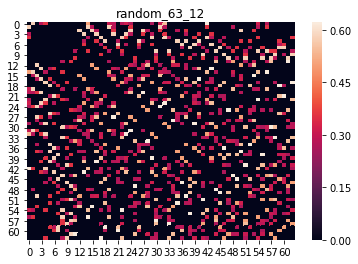

NetworkXError: Graph has no nodes or edges

In [62]:
for n in random.sample(nets,10):
    m = nx.adjacency_matrix(n[1]).todense()
    hm = sns.heatmap(m)
    plt.title(n[0])
    plt.show()

In [57]:
for n in nets:
    if len(n[1].edges()) > 0:
        view = atools.buildNetworkView(n[1])
        print n[0]
        hv.ipython.display(view)
    else:
        plot = makeParticleModelFromPhenome(zoo[n[0]])
        plot.display()

random0


random1


random2


random3


random4


random5


random6


random7


random8


random9


In [32]:
netFilePath = 'db/zoo-nets-rand.csv'

with open(netFilePath, 'w') as netFile:

    netWriter = atools.UnicodeWriter(netFile)

    netWriter.writerows([[
            "Name",
            "Density",
            "Max Diameter",
            "Mean Diameter",
            "Min Radius",
            "Average Radius",
            "Subgraph Number",
            "Estrada Coefficient"
            ]])

    for n in nets:
        pN = n[1]
        density = nx.density(pN)
        graphs = list(nx.connected_component_subgraphs(pN))
        dS = []
        rS = []
        for g in graphs:
            d = nx.diameter(g)
            r = nx.radius(g)
            dS.append(d)
            rS.append(r)
        maxDiameter = np.max(dS)
        avgDiameter = np.mean(dS)
        minRadius = np.min(rS)
        avgRadius = np.mean(rS)
        subgraphs = len(graphs)
        estrada = nx.estrada_index(pN)

        netWriter.writerows([[
            str(n[0]),
            str(density),
            str(maxDiameter),
            str(avgDiameter),
            str(minRadius),
            str(avgRadius),
            str(subgraphs),
            str(estrada)
        ]])

# Analysis

In [33]:
def makeHeatmap(array,label,annot=False):
    df = pd.DataFrame.from_dict(np.array(array).T)
    df.columns = ['Ligand Number','Affinity (kT)',label]
    df['Z_value'] = pd.to_numeric(df[label])
    pf = df.pivot('Affinity (kT)','Ligand Number',label)
    return sns.heatmap(pf, cmap="cool",annot=False, fmt='.1f')

In [34]:
typeData = {}
netData = {}

with open('db/zoo.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        rowsplit = ', '.join(row).split(',')
        ftype = rowsplit[0].split('_')
        ptype = ftype[0]
        nlig = int(ftype[1])
        teps = int(ftype[2])
        if not ptype in typeData:
            typeData[ptype] = {}
        if not nlig in typeData[ptype]:
            typeData[ptype][nlig] = {}
        if not teps in typeData[ptype][nlig]:
            typeData[ptype][nlig][teps] = [float(i) for i in rowsplit[1:]]

with open('db/zoo-nets.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    rowNum=0
    measures = []
    for row in spamreader:
        if rowNum>0:
            rowsplit = ', '.join(row).split(',')
            ftype = rowsplit[0].split('_')
            ptype = ftype[0]
            nlig = int(ftype[1])
            teps = int(ftype[2])
            if not ptype in netData:
                netData[ptype] = {}
            if not nlig in netData[ptype]:
                netData[ptype][nlig] = {}
            if not teps in netData[ptype][nlig]:
                netData[ptype][nlig][teps] = {}
            colNum = 1
            for m in measures[1:]:
                if not m in netData[ptype][nlig][teps]:
                    netData[ptype][nlig][teps][m] = rowsplit[colNum]
                colNum +=1
            if not 'Fitness' in netData[ptype][nlig][teps]:
                netData[ptype][nlig][teps]['Fitness'] = typeData[ptype][nlig][teps][2]
            if not 'BudTime' in netData[ptype][nlig][teps]:
                netData[ptype][nlig][teps]['BudTime'] = typeData[ptype][nlig][teps][4]
        else:
            measures = ''.join(row).split(',')
        rowNum+=1

fitnesses = {}
budtimes = {}
ptypes = []

for t,v in typeData.iteritems():
    ptypes.append(t)
    if not t in fitnesses:
        fitnesses[t] = []
    if not t in budtimes:
        budtimes[t] = []           
    for nl,v in typeData[t].iteritems():
        for eps,v2 in v.iteritems():
            fitnesses[t].append([nl,eps,v2[2]])
            budtimes[t].append([nl,eps,v2[4]])
        

ValueError: invalid literal for int() with base 10: 'rm'

In [260]:
def splitToXYZ(array):
    x = np.array(array)[:, 0]
    y = np.array(array)[:, 1]
    z = np.array(array)[:, 2]
    return [x,y,z]

In [274]:
def splitToXYZwithNaNs(array):
    x = np.array(array)[:, 0]
    y = np.array(array)[:, 1]
    z = np.array(array)[:, 2]
    for i in range(len(z)):
        if z[i] < 0:
            z[i] = np.NaN
    return [x,y,z]

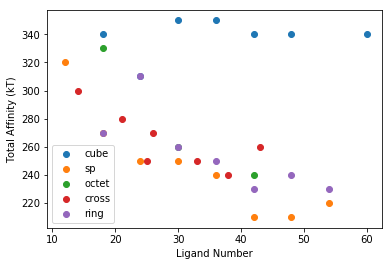

In [365]:
typeScatter = []
for t in ptypes:
    narr = np.array(budtimes[t])
    steps = list(set(narr[:,0]))
    clumps = [narr[np.where(narr[:,0] == s)] for s in steps]
    maxNonZeroes = []
    for c in clumps:
        maxNonZero = -1
        bVal = [c[0]]
        for v in c:
            if v[-1] > 0 and v[-1] > maxNonZero:
                maxNonZero = v[-1]
                bVal = v[0:2]
        if maxNonZero != -1:
            maxNonZeroes.append(list(bVal))
    typeScatter.append(maxNonZeroes)

for t in range(len(typeScatter)):
    x = np.array(typeScatter[t])[:, 0]
    y = np.array(typeScatter[t])[:, 1]
    plt.scatter(x, y,label=ptypes[t])
plt.legend()
plt.xlabel('Ligand Number')
plt.ylabel('Total Affinity (kT)')
plt.show()

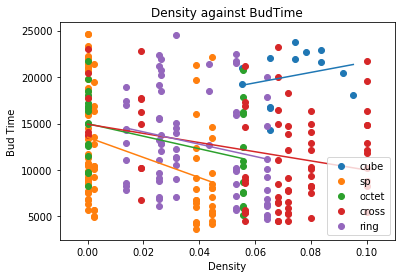

not enough data available in cube


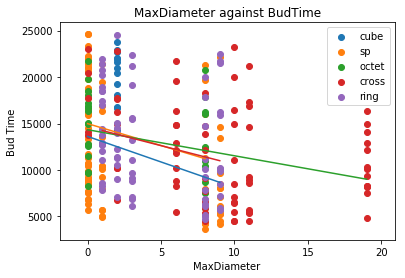

not enough data available in cube


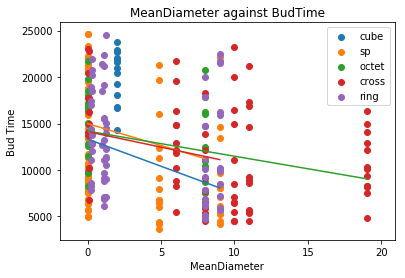

not enough data available in cube


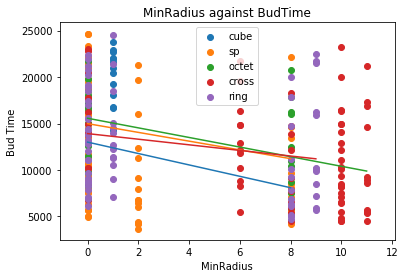

not enough data available in cube


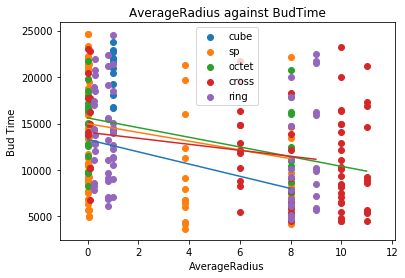

not enough data available in cube


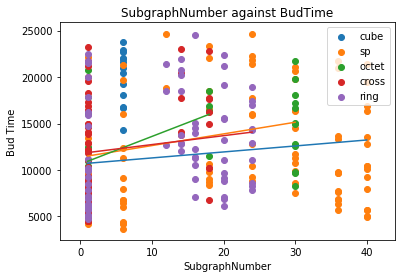

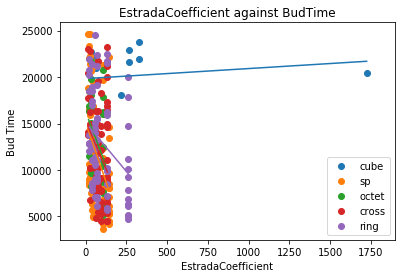

In [437]:
for m in measures[1:]:
    minX = 1e8
    maxX = -1e8
    for t in ptypes:
        x = []
        y = []
        for nlig,v1 in netData[t].iteritems():
            for eps,v2 in v1.iteritems():
                if v2['BudTime']>0:
                    x.append(float(v2[m]))
                    y.append(v2['BudTime'])
        plt.scatter(x, y,label=t,alpha=1.0)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
            except np.RankWarning:
                print "not enough data available in " + t
                
        
        if min(x) < minX:
            minX = min(x)
        if max(x) > maxX:
            maxX = max(x)
    plt.legend()
    plt.title(m + " against BudTime")
    plt.xlabel(m)
    
    rang = maxX-minX
    plt.xlim(minX-0.1*rang, maxX+0.1*rang)
    plt.ylabel('Bud Time')
    plt.show()

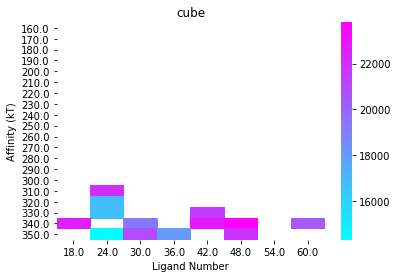

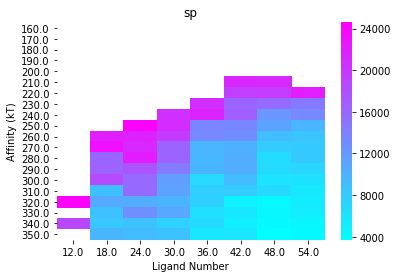

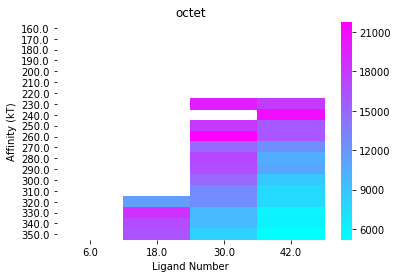

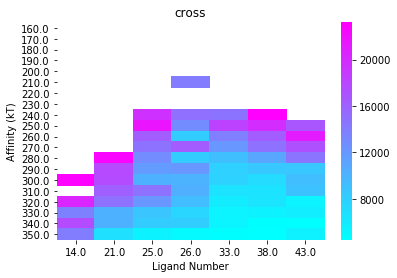

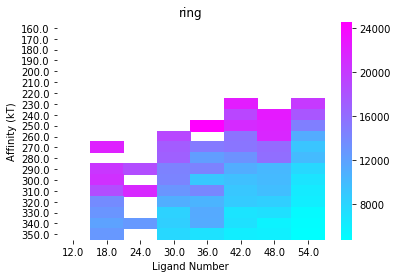

In [357]:
for t in ptypes:
    makeHeatmap(splitToXYZwithNaNs(budtimes[t]),"Budtimes",annot=True)
    plt.title(t)
    plt.show()